## Jupyter notebook for testing an image

Code from [tests/test_snapshot.py](tests/test_snapshot.py)

required packages 

1. Tensorflow

2. Other packages
```
pip install tqdm chainer
```

In [1]:
import numpy as np
import copy
import os
import sys
import math
from tqdm import tqdm
from scripts import dataset
from scripts import config

import scripts.regressionnet
from scripts.regressionnet import batch2feeds, calculate_metric




In [2]:

%load_ext autoreload
%autoreload 2


# this was main function
dataset_name = 'met-ub'

if dataset_name not in ['met', 'met-ub', 'lsp', 'mpii']:
    raise ValueError('Unknown dataset: {}'.format(dataset_name))

if dataset_name == 'mpii':
    TEST_CV_FILEPATH = os.path.join(config.MPII_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.MPII_DATASET_ROOT, 'images')
    symmetric_joints = "[[12, 13], [11, 14], [10, 15], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -100500
elif dataset_name == 'lsp': # LSP dataset
    TEST_CV_FILEPATH = os.path.join(config.LSP_DATASET_ROOT, 'test_joints.csv')
    IMG_PATH_PREFIX = os.path.join(config.LSP_DATASET_ROOT, 'images')
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
elif dataset_name == 'met': # MET dataset
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity1.csv') # test only one image
    TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity.csv')
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_wo.csv')
    # for debugging
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'writing46.csv')  # with valid joints info
    #TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'writing46nv.csv')  # without valid joints info
    IMG_PATH_PREFIX = os.path.join(config.MET_DATASET_ROOT)
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
elif dataset_name == 'met-ub': # MET dataset with upper body 
    TEST_CV_FILEPATH = os.path.join(config.MET_DATASET_ROOT, 'activity_wo_ub.csv')
    IMG_PATH_PREFIX = os.path.join(config.MET_DATASET_ROOT)
    symmetric_joints = "[[8, 9], [7, 10], [6, 11], [2, 3], [1, 4], [0, 5]]"
    ignore_label = -1
else:
    pass
 
    
print(TEST_CV_FILEPATH)
print(IMG_PATH_PREFIX)

test_dataset = dataset.PoseDataset(
    TEST_CV_FILEPATH,
    IMG_PATH_PREFIX, 227,
    fliplr=False, rotate=False,
    shift=None,
    #bbox_extension_range=(1.0, 1.0),
    bbox_extension_range=(1.4, 1.4),
    coord_normalize=True,
    gcn=True,
    fname_index=0,
    #joint_index=1, joint_index_end=29,
    joint_index=13, joint_index_end=29,
    symmetric_joints=symmetric_joints,
    ignore_label=ignore_label,
    should_return_bbox=True,
    should_downscale_images=True,
    downscale_height=400
)

print("data ready")



15it [00:00, 121.51it/s]

/var/data/MET2/activity_wo_ub.csv
/var/data/MET2
Reading dataset from /var/data/MET2/activity_wo_ub.csv
Downscale images to the height 400px


539it [00:02, 251.27it/s]

Joints shape: (8, 2)
data ready


In [3]:
#test_dataset.get_original_image(0)
print(test_dataset.joints)
print(test_dataset.info)

[('image/office activities/walking about/1.png', array([[146., 120.],
       [143., 100.],
       [135.,  73.],
       [112.,  72.],
       [105.,  98.],
       [ 98., 113.],
       [122.,  68.],
       [121.,  50.]])), ('image/office activities/walking about/10.png', array([[161., 113.],
       [163.,  91.],
       [170.,  56.],
       [212.,  56.],
       [217.,  85.],
       [217., 113.],
       [190.,  47.],
       [189.,  25.]])), ('image/office activities/walking about/11.jpg', array([[ 84., 173.],
       [ 66., 133.],
       [ 58.,  66.],
       [ 69.,  59.],
       [ 63., 110.],
       [ 72., 150.],
       [ 70.,  37.],
       [ 73.,   6.]])), ('image/office activities/walking about/12.jpg', array([[220., 106.],
       [216.,  79.],
       [207.,  35.],
       [161.,  45.],
       [156.,  79.],
       [163., 105.],
       [186.,  27.],
       [185.,   7.]])), ('image/office activities/walking about/13.jpg', array([[105.,  84.],
       [140.,  71.],
       [130.,  36.],
       [

[[ 0.35022026  0.35462552]
 [ 0.30616742  0.15198237]
 [ 0.18722469 -0.12555066]
 [-0.14757711 -0.13436124]
 [-0.25330395  0.12995595]
 [-0.35462555  0.28414094]
 [-0.00220263 -0.17400882]
 [-0.0154185  -0.35903084]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]
{'bbox': array([88, 36, 68, 98]), 'orig_tightest_bbox': array([98., 50., 48., 70.]), 'image_id': 'image/office activities/walking about/1.png'}
[[-0.35022026  0.35462552]
 [-0.30616742  0.15198237]
 [-0.18722469 -0.12555066]
 [ 0.14757711 -0.13436124]
 [ 0.25330395  0.12995595]
 [ 0.35462555  0.28414094]
 [ 0.00220263 -0.17400882]
 [ 0.0154185  -0.35903084]]
[[-0.35022026  0.35462552]
 [-0.30616742  0.15198237]
 [-0.18722469 -0.12555066]
 [ 0.14757711 -0.13436124]
 [ 0.25330395  0.12995595]
 [ 0.35462555  0.28414094]
 [ 0.00220263 -0.17400882]
 [ 0.0154185  -0.35903084]]


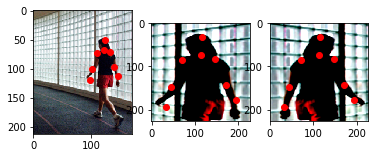

In [5]:
# let's check images and joints are correctly loaded

from matplotlib import pyplot as plt
%matplotlib inline

imageIdx = 0   # this image has only upper body
#imageIdx = 89   # this image missis head top joint
#imageIdx = 101   # this image has only upper body


## 1. original image 
img=test_dataset.get_original_image(imageIdx)


## 2. scaled image & info
image, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)
valid_joints = joints[is_valid_joints].reshape(-1,2)

bbox=misc['bbox']
#bbox=misc['orig_tightest_bbox']

print(joints)
print(is_valid_joints)
#print(valid_joints)
print(misc)


## 3. flipped image 
import cv2 as cv 

# flip image horizontally
image_flipped=cv.flip(image,1)  

# flip coordinates
valid_joints_flipped = valid_joints
valid_joints_flipped[:,0] = -valid_joints[:,0]  # flip x coordinate

print(valid_joints)
print(valid_joints_flipped)


# function for plotting
def plotImageAndJoints(image, valid_joints, bbox=None):
    """ 
        plot image and joints using matplotlib
    """
    plt.imshow(image[:,:,::-1])
    if bbox is None:
        offsetX = 0
        offsetY = 0
        W = image.shape[0]
        H = image.shape[1]
    else:
        offsetX = bbox[0]
        offsetY = bbox[1]
        W = bbox[2]
        H = bbox[3]
        
    # print(W,H)
    plt.plot((valid_joints[:,0]+0.5)*W+offsetX, (valid_joints[:,1]+0.5)*H+offsetY,'or')


plt.clf
plt.subplot(131)
plotImageAndJoints(img, valid_joints, bbox)


plt.subplot(132)
plotImageAndJoints(image, valid_joints)

plt.subplot(133)
plotImageAndJoints(image_flipped, valid_joints_flipped)





In [ ]:
# load creat regressionnet and load weight from snapshot 

snapshot_path = '/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000'
# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/mpii_alexnet_imagenet/checkpoint-10000')
# init_snapshot_path = os.path.join(config.ROOT_DIR, 'out/lsp_alexnet_scratch/checkpoint-10000')

from scripts import regressionnet

net, loss_op, pose_loss_op, train_op = regressionnet.create_regression_net(
    n_joints=16 if dataset_name == 'mpii' else 14,
    init_snapshot_path=snapshot_path,
    is_resume=True,
    net_type='Alexnet',
    optimizer_type='momentum',
    gpu_memory_fraction=0.32)  # Set how much GPU memory to reserve for the network

print(net)
print(snapshot_path)

In [ ]:
print("start testing")

# predict joints
batch_size=128
avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = regressionnet.predict(net, pose_loss_op, test_dataset, batch_size, dataset_name=dataset_name, tag_prefix='test')

In [ ]:
#print(gt_joints.shape)
print(gt_joints)
print(gt_joints_is_valid)
#print(predicted_joints.shape)
print(predicted_joints)

In [ ]:
# save predicted joints coordination to prectedJointsMET_1000_14.txt
n, numJoints, dim = predicted_joints.shape
np.savetxt('prectedJointsMET_{}_{}.txt'.format(n,numJoints),predicted_joints.reshape(-1,numJoints*dim), delimiter=',')

# TODO: convert to image coordinate before saving!


In [ ]:
# get valid joints!
def get_valid_joints(joints, is_valid_joints):
    valid_joints = []
    for i, joint in enumerate(joints):
        if is_valid_joints is not None \
                and (is_valid_joints[i][0] == 0 or is_valid_joints[i][1] == 0):
            continue
        valid_joints.append(joint)
    return np.asarray(valid_joints)


gt_valid_joints = get_valid_joints(gt_joints[imageIdx],gt_joints_is_valid[imageIdx])
#print(gt_valid_joints)

predicted_valid_joints = get_valid_joints(predicted_joints[imageIdx],gt_joints_is_valid[imageIdx])



x = gt_valid_joints[:,1]
xhat = predicted_valid_joints[:,0]
y = gt_valid_joints[:,1]
yhat = predicted_valid_joints[:,1]

# # need to compare only valid joints!
# xValid = gt_joints_is_valid[imageIdx][:,0]
# yValid = gt_joints_is_valid[imageIdx][:,1]


plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [ ]:
# TODO: plot predicted joints on the image!

from matplotlib import pyplot as plt
%matplotlib inline

imageIdx = 0   # this image has only upper body
#imageIdx = 101   # this image has only upper body
img=test_dataset.get_original_image(imageIdx)


image, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)

#valid_joints = joints[is_valid_joints].reshape(-1,2)

bbox=misc['orig_tightest_bbox']




plt.subplot(121)
plt.imshow(img[:,:,::-1])
# plot joints
offsetX = bbox[0]
offsetY = bbox[1]
W = bbox[2]#-bbox[0]
H = bbox[3]#-bbox[1]
print(W,H)
plt.plot((gt_valid_joints[:,0]+0.5)*W+offsetX, (gt_valid_joints[:,1]+0.5)*H+offsetY,'or')
plt.plot((predicted_valid_joints[:,0]+0.5)*W+offsetX, (predicted_valid_joints[:,1]+0.5)*H+offsetY,'ob')



plt.subplot(122)
# plot joints
plt.imshow(image[:,:,::-1])
W = image.shape[0]
H = image.shape[1]
print(W,H)
plt.plot((gt_valid_joints[:,0]+0.5)*W, (gt_valid_joints[:,1]+0.5)*H,'or')
plt.plot((predicted_valid_joints[:,0]+0.5)*W, (predicted_valid_joints[:,1]+0.5)*H,'ob')

print(joints)
print(is_valid_joints)   # NOT CORRECT!!!
print(valid_joints)
print(misc)


In [ ]:
# calc PCP
PCPs = list()
for ext in np.linspace(1.0, 2.0, 6, True):
    print('\n====================')
    print('BBOX EXTENSION:', ext)
    test_dataset.bbox_extension_range = (ext, ext)
    

    # predict joints
    batch_size=128
    avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = regressionnet.predict(net, pose_loss_op, test_dataset, batch_size, dataset_name=dataset_name, tag_prefix='test')

    
    # calc metric
    pcp_per_stick = scripts.regressionnet.calc_pcp(global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes, dataset_name)        
    PCPs.append(pcp_per_stick[0])

In [ ]:
PCPs=np.vstack(PCPs)
print(PCPs)
plt.plot(np.asmatrix(PCPs).transpose())

In [ ]:
# plot by parts

from poseevaluation.pcp import average_pcp_left_right_limbs
pcp_per_part, part_names = average_pcp_left_right_limbs(PCPs[1]) # BBOX_EXT = 1.2

print(part_names)
print(pcp_per_part)
    

### Test one image

In [ ]:
pass

image_ori = test_dataset.images['image/office activities/walking about/1.png']
#?test_dataset
#test_dataset.get_example(0)
image, joints, is_valid_joints, misc = test_dataset.get_example(0)

# plot
from matplotlib import pyplot as plt
%matplotlib inline

plt.subplot(121)
plt.imshow(image_ori[:,:,::-1], interpolation = 'bicubic')
plt.subplot(122)
plt.imshow(image[:,:,::-1], interpolation = 'bicubic')

In [ ]:
from chainer import iterators
test_it = iterators.MultiprocessIterator(test_dataset, batch_size=batch_size,
                                             repeat=False, shuffle=False,
                                             n_processes=1, n_prefetch=1)
    # http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

for i, batch in enumerate(test_it):
    print(batch[0][0].shape)
    print(batch[0][1].shape)
    print(batch[0][2].shape)

In [ ]:
# check image size
# img = test_dataset.images['image/office activities/walking about/1.png']
# print(img.shape)
# j = test_dataset.joints
# print(j)


# plot one image from the data
imageIdx = 0


img=test_dataset.get_original_image(imageIdx)
h,w,d=img.shape
print(h,w,d)  # 169 95 3

# joints has all the info loaded from test_joints.csv
img_id, joints = test_dataset.joints[imageIdx]
print(img_id)  # /var/data/lsp/images/im1001.jpg
print(joints)  # [[ 42.96321929 138.35880369]


#print(test_dataset.images)
img, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx)
h,w,d=img.shape
print(h,w,d)   # 227 227 3
print(joints)  # [[-0.06828195  0.42070484]

#print(test_dataset[imageIdx][0].shape)
#print(test_dataset[imageIdx][1].shape)
#print(test_dataset[imageIdx][2].shape)


# calc PCP
for ext in np.linspace(1.0, 2.0, 6, True):
    print('\n====================')
    print('BBOX EXTENSION:', ext)
    test_dataset.bbox_extension_range = (ext, ext)
    

    # calc metric
    scripts.regressionnet.calc_pcp(global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes, dataset_name)
        
    """
    scripts.regressionnet.evaluate_pcp(net, pose_loss_op, test_iterator, None,
                                       dataset_name=dataset_name,
                                       tag_prefix='test')
    """

In [ ]:
# predict one image 
from cv2 import imread, resize

# load an image  (code from load_images in scripts/dataset.py)
img_path='/var/data/MET2/image/office activities/walking about/1.png'
image = imread(img_path)  # HWC BGR image
print(image.shape)
#downscale image if needed
downscale_height = 400
if image.shape[0] > downscale_height:
    downscale_factor = float(image.shape[0]) / self.downscale_height
    image = resize(image, None, fx=1.0/downscale_factor, fy=1.0/downscale_factor)
                


# code from predict in scripts/regressionnet.py

feed_dict = {
        net.x: image,   # should be in the shape of (?, 227, 227, 3)
        #'pose_input/joints_gt:0': joints_gt,
        #'pose_input/joints_is_valid:0': joints_is_valid,
        'input/is_phase_train:0': False,   # testing!
        'lr/conv_lr:0': 0.0,
        'lr/fc_lr:0': 0.0
    }

pred_j, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)

In [ ]:
# code from regressionnet.fill_joint_feed_dict
def fill_joint_feed_dict(net, batch_feeds,
                         conv_lr=None, fc_lr=None,
                         phase='test', train_keep_prob=0.4):
    """Fills the feed_dict for training the given step.

    A feed_dict takes the form of:
    feed_dict = {
        <placeholder>: <tensor of values to be passed for placeholder>,
        ....
    }

    Args:
      batch_loader: BatchLoader, that provides batches of the data
      images_pl: The images placeholder, from placeholder_inputs().
      labels_pl: The labels placeholder, from placeholder_inputs().

    Returns:
      feed_dict: The feed dictionary mapping from placeholders to values.
    """
    if phase not in ['train', 'test']:
        raise ValueError('phase must be "train" or "test"')
    if phase == 'train':
        keep_prob = train_keep_prob
        is_phase_train = True
    else:
        keep_prob = 1.0
        is_phase_train = False

    if len(batch_feeds) != 3:
        raise ValueError('feeds must contain only 3 elements: images, joints_gt, joints_is_valid')
    images, joints_gt, joints_is_valid = batch_feeds

    feed_dict = {
        net.x: images,
        'pose_input/joints_gt:0': joints_gt,
        'pose_input/joints_is_valid:0': joints_is_valid,
        'input/is_phase_train:0': is_phase_train,
        'lr/conv_lr:0': conv_lr,
        'lr/fc_lr:0': fc_lr
    }

    try:
        keep_prob_pl = net.graph.get_tensor_by_name('input/dropout_keep_prob:0')
        dropout_params = {keep_prob_pl: keep_prob}
    except KeyError:
        dropout_params = {'fc6/keep_prob_pl:0': keep_prob,
                          'fc7/keep_prob_pl:0': keep_prob}
    feed_dict.update(dropout_params)
    return feed_dict

In [ ]:
# code from regressionnet.evaluate_pcp
summary_writer = None
tag_prefix='test'

total_loss = 0.0

num_joints = int(int(net.fc_regression.get_shape()[1]) / 2)
gt_joints = list()
gt_joints_is_valid = list()
predicted_joints = list()
orig_bboxes = list()
    

test_it = copy.copy(test_iterator)
num_test_examples = len(test_it.dataset)
num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
for i, batch in tqdm(enumerate(test_it), total=num_batches):

        # uncomment a breakpoint here for debugging
        # import pdb; pdb.set_trace()

        feeds = batch2feeds(batch)
        feed_dict = fill_joint_feed_dict(net,
                                         feeds[:3],
                                         conv_lr=0.0,
                                         fc_lr=0.0,
                                         phase='test')

        pred_j, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)
        total_loss += batch_loss_value * len(batch)
        predicted_joints.append(pred_j.reshape(-1, num_joints, 2))

        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

In [ ]:
# estimated joints
imageIdx = 0
print(predicted_joints[imageIdx][0].shape)
print(predicted_joints[imageIdx][0])
xhat = predicted_joints[imageIdx][0][:,0]
yhat = predicted_joints[imageIdx][0][:,1]

In [ ]:
import cv2
from matplotlib import pyplot as plt
%matplotlib inline


# plot example image (normalized)
img, joints, is_valid_joints, misc = test_dataset.get_example(imageIdx, gcn=None, bbox_extension_range=None, shift=None)
print(joints)

#img = test_dataset.get_original_image(imageIdx)  # 169 95 3


h,w,d=img.shape
print(h,w,d)    # 227 227 3

x = joints[:,0]
print([min(x), max(x)])
y = joints[:,1]
print([min(y), max(y)])

#cv2.imshow('image',img)
#if cv2.waitKey(10) & 0xFF == 27:
#        print("quit")
#        break
#cv2.destroyAllWindows()

In [ ]:
plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [ ]:
def plotJoints(img, joints, color=(255,255,255)):
    img = img.copy()
    numJoints, t = joints.shape
    #numJoints, t = predicted_joints[0].shape #joints.shape
    #print(numJoints,t)

    circSize=10
    font = cv2.FONT_HERSHEY_SIMPLEX

    #cv2.drawKeypoints(img,joints,img)
    for i in range(numJoints):
        #print(joints[i,:])
        x = joints[i,0]
        y = joints[i,1]
        #x = predicted_joints[0][0][i,0]
        #y = predicted_joints[0][0][i,1]

        # transform 
        xx = int(w/2 + w*x)
        yy = int(h/2 + h*y)    
        #print(x,y)

        cv2.circle(img, (xx, yy), 5, color) #, -1)

        cv2.putText(img, str(i+1), (xx,yy), font, 0.5, (255,255,255), 1, cv2.LINE_AA)
    #    cv2.text(img, (x, y), 5, (255, 0, 0)) #, -1)
        # https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
    
    return img 

plt.subplot(121)
img1=plotJoints(img,joints, (255,0,0))
plt.imshow(img1[:,:,::-1], interpolation = 'bicubic')
#plt.imshow(img[:,:,0], cmap='gray', interpolation = 'bicubic')

plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.subplot(122)
plotJoints(img, predicted_joints[imageIdx][0])
#plt.imshow(img[:,:,::-1], cmap = 'gray', interpolation = 'bicubic')
plt.imshow(img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()


In [ ]:
#plt.imshow(img, vmin = -2, vmax = 2)
#plt.show()
print(img.shape)
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.imshow(img, cmap='gray', vmin = -2, vmax = 2, interpolation = 'bicubic')
#ax.autoscale(True)



In [ ]:
#print(img*0.5)
I = np.minimum(np.maximum(img*0.5,-1),1)
print(I)

from skimage import data, io, filters
io.imshow(I)
io.show()

### Example to get test data

In [ ]:
#print(test_iterator)
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

for i, batch in enumerate(test_iterator): 
    print(i, batch)

In [ ]:
def get_gt_data(test_iterator):
    test_it = copy.copy(test_iterator)
    num_test_examples = len(test_it.dataset)
    num_batches = int(math.ceil(num_test_examples / test_it.batch_size))
    gt_joints = list()
    gt_joints_is_valid = list()
    orig_bboxes = list()

    print(len(test_it.dataset))
    for i, batch in tqdm(enumerate(test_it), total=num_batches):
        feeds = batch2feeds(batch)
        gt_joints.append(feeds[1])
        gt_joints_is_valid.append(feeds[2])
        orig_bboxes.append(np.vstack([x['bbox'] for x in feeds[3]]))

    gt_joints = np.vstack(gt_joints)
    gt_joints_is_valid = np.vstack(gt_joints_is_valid)
    orig_bboxes = np.vstack(orig_bboxes)
    return gt_joints, gt_joints_is_valid, orig_bboxes

In [ ]:
test_iterator = iterators.MultiprocessIterator(
    test_dataset, batch_size=128,
    repeat=False, shuffle=False,
    n_processes=1, n_prefetch=1)
# http://docs.chainer.org/en/stable/reference/generated/chainer.iterators.MultiprocessIterator.html

gt_joints, gt_joints_is_valid, orig_bboxes = get_gt_data(test_iterator)

print(gt_joints.shape)
print(gt_joints_is_valid.shape)
print(orig_bboxes.shape)

In [ ]:
orig_bboxes

In [ ]:
print(test_dataset)